<div style="text-align: center; font-size: 32px;">Introduction to WindEurope Annual Event 2024 Hackathon Data Analysis with HubOcean's collaboration</div>

![Hack The Climate](Flag_hackathon.png)

    Welcome to our analytical notebook for the WindEurope Annual Event 2024 Hackathon. In this notebook, we will explore a vestas dataset sample encompassing both wind speed, direction measurements in the context of the WindEurope Hackathon. Our focus will be on providing insight about different data structures that could be used to perform data analysis. We will visualize the data and hope to inspire or trigger innovative ideas for the candidates. 

    What you get in this notebook:
    
        1. The process to go from the sampling csv file to a multidimensional dataset xarray with two variables, wind speed and wind direction, with dimension (time, lon, lat, altitude)
        2. A brief analysis to visualize the dominant trend for wind speed and direction
        3. An example of temporal signal processing using Fourier on transform on a selected point to highlight cycle or denoise the signal.
        4. An example of how to go from a non-uniform grid to a uniform gridded data in order to perform spatial analysis. In our example we demonstrate how to calculate the relative voriticty.

In [1]:
# Import and data preprocessing
!pip install basemap --quiet
!pip install haversine --quiet

from mpl_toolkits.basemap import Basemap
from haversine import haversine, Unit
import zipfile
import pandas as pd
import numpy as np
import xarray as xr
from windrose import WindroseAxes
import matplotlib.cm as cm
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from scipy.signal import butter, filtfilt
import pyproj


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
zip_file_path = 'vcl_ts_-74.14687_-73.61269_40.08408_40.49947.zip'
csv_filename = 'vcl_ts_-74.14687_-73.61269_40.08408_40.49947.csv'
save_to = '.'

In [3]:
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extract(csv_filename, '.')

In [4]:
df = pd.read_csv('vcl_ts_-74.14687_-73.61269_40.08408_40.49947.csv', header=13, index_col=0)
if len(df['dx'].unique())==1:
    dx = df['dx'].unique()
    df = df.drop(['dx'], axis=1)
df

,xlat,xlong,wsp_50.0,wsp_150.0,wdir_50.0,wdir_150.0
timestamp,,,,,,
2022-07-30 01:00:00,40.458183,-73.735291,6.449413,7.997170,231.2919,239.1616
2022-07-30 02:00:00,40.458183,-73.735291,3.690546,4.620010,327.7978,339.9860
2022-07-30 03:00:00,40.458183,-73.735291,3.246318,4.587146,341.0561,328.0266
2022-07-30 04:00:00,40.458183,-73.735291,2.796064,4.072270,340.1899,332.6730
2022-07-30 05:00:00,40.458183,-73.735291,1.489764,2.298835,4.9626,315.0391
...,...,...,...,...,...,...
2022-07-27 06:00:00,40.356522,-74.039001,4.066001,5.762965,264.1797,269.4905
2022-07-27 07:00:00,40.356522,-74.039001,2.249471,1.344601,237.0524,24.9884
2022-07-27 08:00:00,40.356522,-74.039001,3.039156,1.858830,247.2791,246.8312


In [5]:
#Checking the boundary of the box
lon_min, lon_max = np.min(df['xlong']), np.max(df['xlong'])
lat_min, lat_max = np.min(df['xlat']), np.max(df['xlat'])
lon = df['xlong']
lat = df['xlat']

print(f'Longitude goes from {lon_min} to {lon_max}')
print(f'Latitude goes from {lat_min} to {lat_max}')

Longitude goes from -74.145813 to -73.61319
Latitude goes from 40.085487 to 40.498051


Text(0.5, 1.0, 'Data Location on East US coastlines')

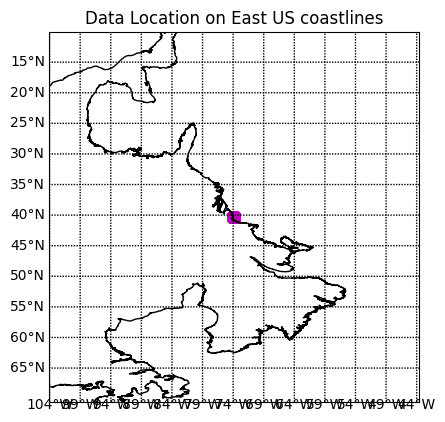

In [6]:
padding=30
fig = plt.figure()

map = Basemap(llcrnrlon=lon_min-padding, llcrnrlat=lat_max+padding, urcrnrlon=lon_max+padding, urcrnrlat=lat_min-padding,
             resolution='i', projection='cyl', lat_0 = 40.2, lon_0 = -73.85)

lon_show, lat_show = df['xlong'], df['xlat']
x,y = map(lon_show, lat_show)

map.scatter(x, y, marker='X',color='m', label='Original')
map.drawcoastlines()

map.drawparallels(np.arange(int(lat_min-padding),int(lat_max+padding),5),labels=[1,0,0,0])
map.drawmeridians(np.arange(int(lon_min-padding),int(lon_max+padding),5),labels=[0,0,0,1])

plt.title('Data Location on East US coastlines')

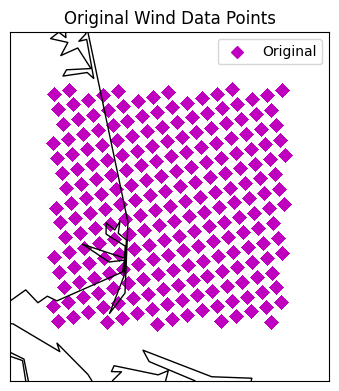

In [7]:
padding = 0.1
fig = plt.figure(figsize=(14,14))

map = Basemap(llcrnrlon=lon_min-padding, llcrnrlat=lat_max+padding, urcrnrlon=lon_max+padding, urcrnrlat=lat_min-padding,
             resolution='i', projection='tmerc', lat_0 = 40.2, lon_0 = -73.85)

ax = fig.add_subplot(131)
x,y = map(lon, lat)

map.scatter(x, y, marker='D',color='m', label='Original')
map.drawcoastlines()
ax.set_title('Original Wind Data Points')
plt.legend()


# Data Structure

We have points distributed as shown on the figure above. The time series of each point start from 01-06-2022 to 31-07-2022 on two altitude level: [50, 150] meters. It is located on the East of USA coastlines.

This dataset offers the possibility to perform calculations on both spatial and temporal dimensions. On the next section, we reshape the data so it fits the two variables, wind speed and wind direction, in a xarray dataset format and will allow to perform indexing and calculations across the different dimension in an optimized way. Pandas also fits to perform an EDA but xarray dataset are particularly appropriate when having multiple variable projected on similar dimensions.

In [8]:
#The variable are wsp and wdir with their altitude such as wsp_50.0 with we do assume 50.0 representing the altitude in meters 
var1 = 'wsp'
var2 = 'wdir'
df_wsp, df_wdir = (pd.DataFrame(index=df.index) for _ in range(2))
altitude = []

for col in df:
    if var1 in col:
        altitude.append(int(float(col.replace(var1+'_', ""))))
        df_wsp[col] = df[col]
    elif var2 in col:
        df_wdir[col] = df[col]
        
altitude = np.array(altitude, dtype = float)

In [9]:
#Get time, lat, lon limit
print('The data starts at {} and ends at {}'.format(df.index.min(), df.index.max()))
print('The latitude starts at {} and ends at {}'.format(df['xlat'].min(), df['xlat'].max()))
print('The longitude starts at {} and ends at {}'.format(df['xlong'].min(), df['xlong'].max()))

The data starts at 2022-06-01 00:00:00 and ends at 2022-07-31 23:00:00
The latitude starts at 40.085487 and ends at 40.498051
The longitude starts at -74.145813 and ends at -73.61319


In [10]:
#What kind of data do we have ? How does the time work ?
len_time=len(df.index.unique())
print(f'The index is timestamp with a length of {len_time} with value as: \n {df.index.unique()}')

The index is timestamp with a length of 1464 with value as: 
 Index(['2022-07-30 01:00:00', '2022-07-30 02:00:00', '2022-07-30 03:00:00',
       '2022-07-30 04:00:00', '2022-07-30 05:00:00', '2022-07-30 06:00:00',
       '2022-07-30 07:00:00', '2022-07-30 08:00:00', '2022-07-30 09:00:00',
       '2022-07-30 10:00:00',
       ...
       '2022-07-29 15:00:00', '2022-07-29 16:00:00', '2022-07-29 17:00:00',
       '2022-07-29 18:00:00', '2022-07-29 19:00:00', '2022-07-29 20:00:00',
       '2022-07-29 21:00:00', '2022-07-29 22:00:00', '2022-07-29 23:00:00',
       '2022-07-30 00:00:00'],
      dtype='object', name='timestamp', length=1464)


In [11]:
#Let's check now if the data has similar location through the time series:
#We sort the value in this order ['timestamp','xlat', 'xlong']
df = df.sort_values(by=['timestamp','xlat', 'xlong'])
df

,xlat,xlong,wsp_50.0,wsp_150.0,wdir_50.0,wdir_150.0
timestamp,,,,,,
2022-06-01 00:00:00,40.085487,-73.734161,12.969553,9.401258,223.9781,243.4458
2022-06-01 00:00:00,40.086239,-74.108093,4.198740,5.634552,303.5624,308.1050
2022-06-01 00:00:00,40.087643,-73.620941,13.225094,11.779918,224.7876,237.1847
2022-06-01 00:00:00,40.088760,-73.994873,3.835602,6.526549,264.0696,292.4161
2022-06-01 00:00:00,40.091175,-73.881653,8.913507,6.432111,221.2417,271.0444
...,...,...,...,...,...,...
2022-07-31 23:00:00,40.492390,-73.759247,7.059191,8.544706,165.9966,180.8677
2022-07-31 23:00:00,40.493057,-74.135406,6.553188,7.073047,154.1829,167.2599
2022-07-31 23:00:00,40.494564,-73.645325,6.792121,8.061359,167.3221,183.1152


In [12]:
#In this cell, we want to verify if every latitude and longitude are the same in every time step
#Do not spend time looking at this cell
#If it does we are allowed to grid the data in a 2 dimension grid: (Time, Location) with Location=(Lat, Lon)
time_dim = df.index.unique()
check=False
if check:
    regular_spatial_grid = True
    
    for i, value in enumerate(time_dim):
        if i==len(time_dim)-1:
            break
        A = df[df.index==value]
        B = df[df.index==time_dim[i+1]]
        test_lat = A['xlat'].values-B['xlat'].values
        test_lon = A['xlong'].values-B['xlong'].values
       
        cond1 = (len(np.unique(test_lat))==1) and (int(test_lat[0])==0)
        cond2 = (len(np.unique(test_lon))==1) and (int(test_lon[0])==0)
        
        if not cond1 or not cond2:
            regular_spatial_grid = False
            break
    
    if regular_spatial_grid:
        print('The location are consistent through the time series. We can grid the data according to 2 dimensions: (Time, Location)')
    
    #A plot with a figure would have been a good enough approximation though ...

In [13]:
#We sort the dataframe
#Another solution could be to pivot the data
#pivot_df = df.pivot_table(index='timestamp', columns=['xlat', 'xlong'], values='wsp_50.0')
#pivot_df
#lat, lon = df['xlat'], df['xlong']

In [14]:
#We create the locations dimension by zipping the latitude and longitude of each position together
df_lat_lon = df[df.index==time_dim[0]][['xlat', 'xlong']].values
longitudes = df_lat_lon[:, 1]  
latitudes = df_lat_lon[:, 0]   
locations = np.array(list(zip(df_lat_lon[:,0], df_lat_lon[:,1])))
locations[0:10]

array([[ 40.085487, -73.734161],
       [ 40.086239, -74.108093],
       [ 40.087643, -73.620941],
       [ 40.08876 , -73.994873],
       [ 40.091175, -73.881653],
       [ 40.093475, -73.768433],
       [ 40.094124, -74.142395],
       [ 40.095673, -73.655182],
       [ 40.096676, -74.029175],
       [ 40.099125, -73.915924]])

In [15]:
#By checking the headers from the dataframe we know that the variable such as wsp, wdir represents different altitude (50, 150)...
var1 = 'wsp'
altitude = []
for col in df:
    if var1 in col:
        altitude.append(int(float(col.replace(var1+'_', ""))))

In [16]:
len_time, time_index = len(time_dim), time_dim
len_lat = len(locations)
len_altitude = len(altitude)

In [17]:
data_array_wsp = np.reshape(df[['wsp_50.0', 'wsp_150.0']].values, (len_time, len_lat, len_altitude))
data_array_wdir = np.reshape(df[['wdir_50.0', 'wdir_150.0']].values, (len_time, len_lat, len_altitude))

In [18]:
data_array_wsp = xr.DataArray(data_array_wsp, 
                              dims=["timestamp", "location", "altitude"],
                              coords={
                                    "time": time_dim,
                                    "location": np.arange(len(locations)),
                                    "longitude": ("location", longitudes),  
                                    "latitude": ("location", latitudes),
                                    "altitude": altitude
                              })

data_array_wdir = xr.DataArray(data_array_wdir, 
                              dims=["timestamp", "location", "altitude"],
                              coords={
                                    "time": time_dim,
                                    "location": np.arange(len(locations)),
                                    "longitude": ("location", longitudes),  
                                    "latitude": ("location", latitudes),
                                    "altitude": altitude
                              })

In [19]:
ds = xr.Dataset({'wind_speed':data_array_wsp,
               'wind_direction': data_array_wdir})

In [20]:
ds

<xarray.Dataset>
Dimensions:         (timestamp: 1464, location: 227, altitude: 2)
Coordinates:
    time            (timestamp) object '2022-06-01 00:00:00' ... '2022-07-31 ...
  * location        (location) int64 0 1 2 3 4 5 6 ... 221 222 223 224 225 226
    longitude       (location) float64 -73.73 -74.11 -73.62 ... -74.02 -73.91
    latitude        (location) float64 40.09 40.09 40.09 ... 40.49 40.5 40.5
  * altitude        (altitude) int64 50 150
Dimensions without coordinates: timestamp
Data variables:
    wind_speed      (timestamp, location, altitude) float64 12.97 9.401 ... 10.1
    wind_direction  (timestamp, location, altitude) float64 224.0 ... 179.2

# Exploratory Data Analysis 

So far in this notebook, the data are untouched and the wind speed, wind direction and positions in the multidimensional dataset freshly created represents strictly the data from the source file but in a better structure to access and index the different variables across different dimensions.

## Trend and Pattern 

The data represents a 2 months time series with different locations measuring wind speed and direction. We here analyze the distribution of these two variables to best describe the main patterns in the data. I.e what is the principal wind component etc ...

Here we select all the data points for the altitude 50 meters and have a look at the wind speed and wind direction distributions. 

In [21]:
# If you want to select the next altitude, change height to 1 and so on.
# Here our dataset sampling only has two different altitudes so the index for this dimension stops to 1
ws = ds['wind_speed'].isel(altitude=0)
wd = ds['wind_direction'].isel(altitude=0)

ws_ravel = np.ravel(ws)
wd_ravel = np.ravel(wd)

wd_ravel

array([223.9781, 303.5624, 224.7876, ..., 167.3221, 159.9388, 165.3614])

Text(0.5, 1.0, 'Wind Speed Distribution related to their direction')

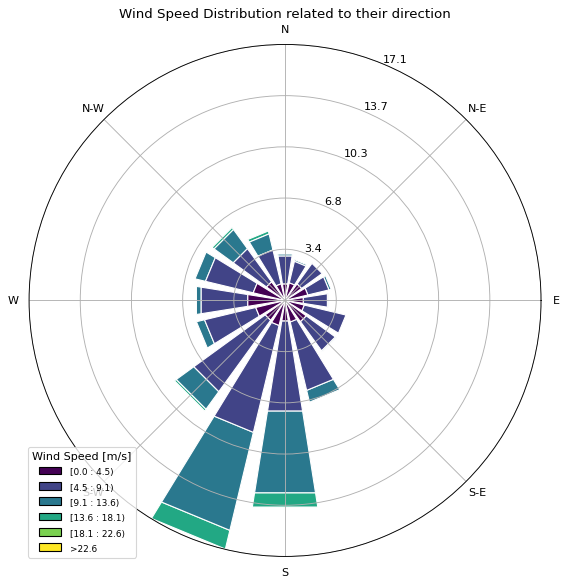

In [22]:
# Plotting a rose to visualize the wind distribution
ax = WindroseAxes.from_ax()
ax.bar(wd_ravel, ws_ravel, normed=True, opening=0.8, edgecolor='white')
ax.set_legend(title='Wind Speed [m/s]')
plt.title('Wind Speed Distribution related to their direction')

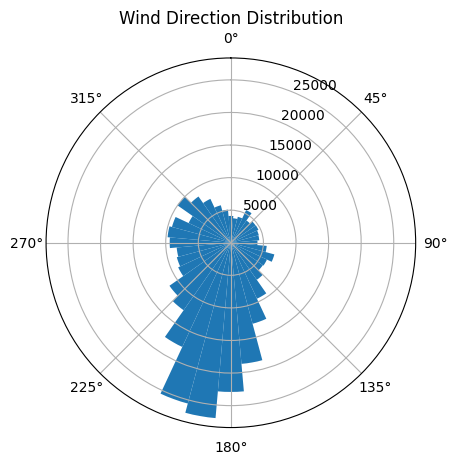

In [23]:
# Number of bins (e.g., 36 for 10-degree bins)
num_bins = 36

# Compute the histogram
counts, bin_edges = np.histogram(wd_ravel, bins=num_bins, range=(0, 360))
counts = np.append(counts, counts[0])

# Create the plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)  

# Adjust theta to have the same length as counts
theta = np.linspace(0.0, 2 * np.pi, num_bins + 1)

# Create bars
bars = ax.bar(theta, counts, width=(2 * np.pi) / num_bins, bottom=0.0)
ax.set_title("Wind Direction Distribution")
plt.show()

From these two windrose figures, we know that the stronger winds speed blow south-west ward. It does show two different possibilities to plot and look at the main pattern for wind speed and direction.

## Time series and Spectral analysis

### Denoising signal and highlight trend and cycle

We now focus on one specific point and chose to select the first point in the location dimension. We did notice a kind of noisy signal while plotting the time serie as shown below in the first graph of the subplot. We provide here an example of code to filter and plot a frequency domain to eventually highlight cyclic trend in our time serie. The main frequency are concentrated on the low frequency. In order to remove noise in the signal we apply a low-pass filter and got a filtered signal looking similar than our original but less noisy.

A careful spectrum analysis did reveal the main frequency occured at 0.0416 per hour which correspond a cyclic trend of 24.0 hours. The best fit for a physical explanation would be the dominant process a thermal wind.


Note: The Fourier transform is used in signal processing to design filters and remove coherent noise. Many filtering operations are performed in the frequency domain. 

In [24]:
wd_series = ds.wind_direction.isel(location=0)
ws_series = ds.wind_speed.isel(location=0)
time = ds.coords['time']
t = np.arange(len(time))

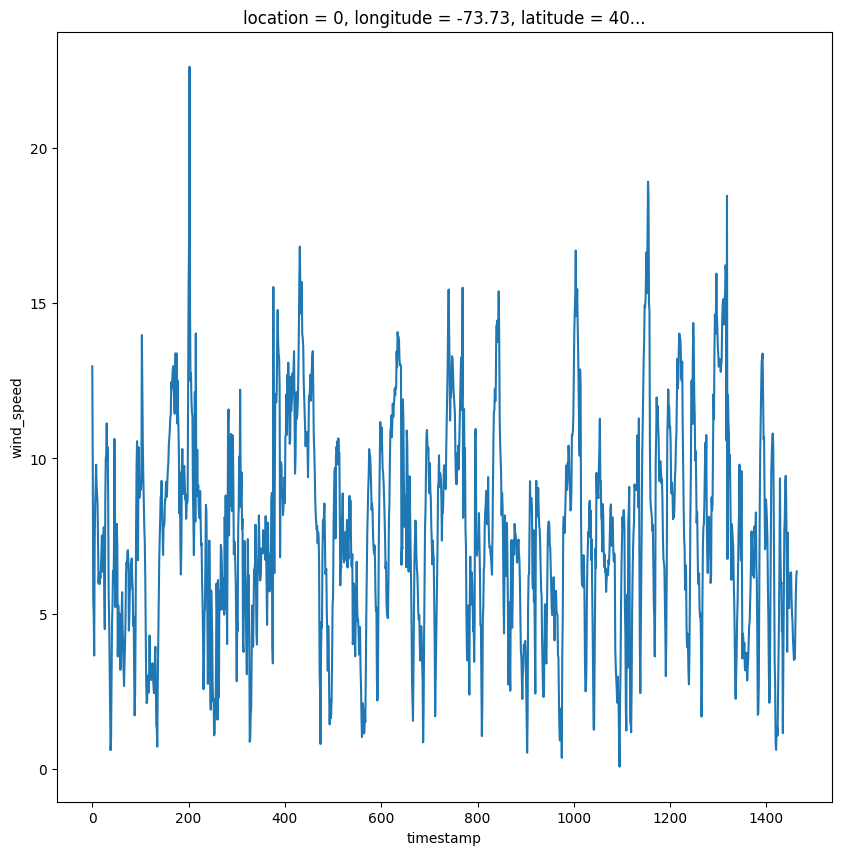

In [25]:
ws_0 = ws_series.isel(altitude=0)
plt.figure(figsize=(10,10))
ws_0.plot()

/Users/xavierpivan/HubOcean/VesselEmissions/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


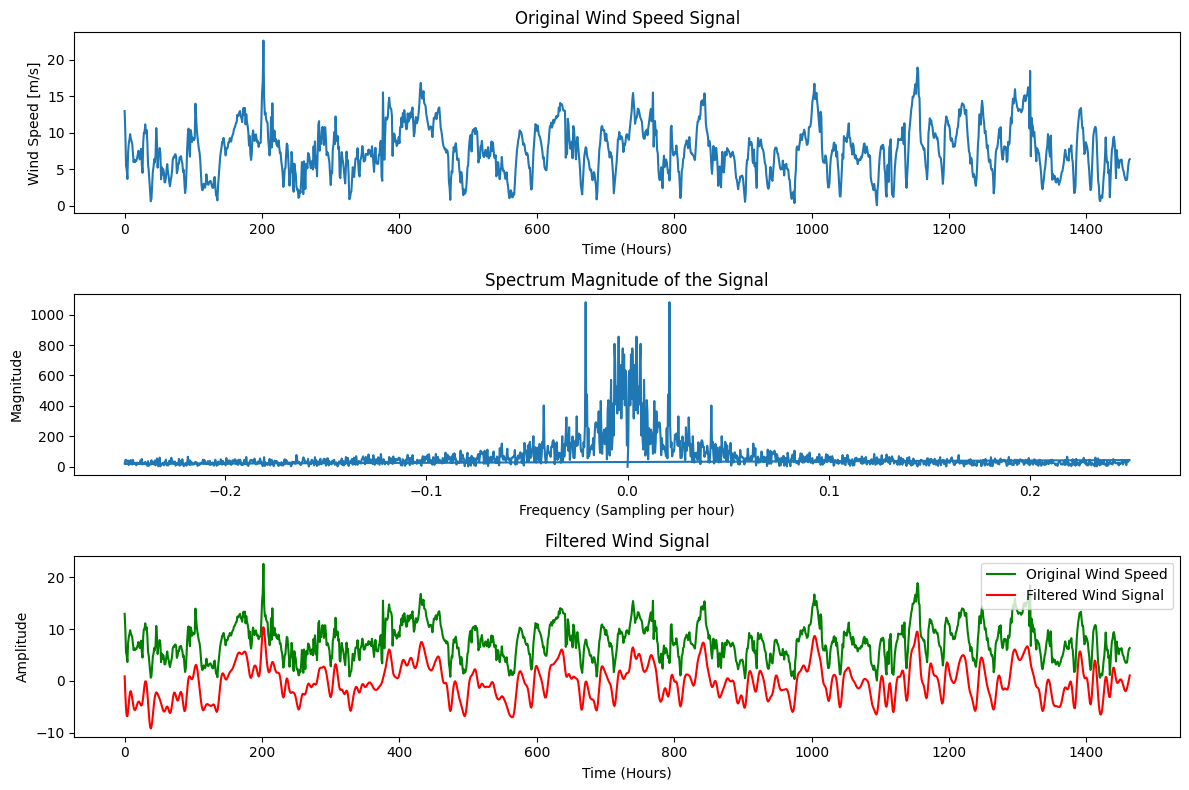

In [26]:
# Function to apply a Butterworth bandpass filter
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    b, a = butter(order, [lowcut/nyquist, highcut/nyquist], btype='band')
    y = filtfilt(b, a, data)
    return y

# Function to perform Fourier Transform
def compute_fourier_transform(signal, sampling_rate):
    n = len(signal)
    freq = np.fft.fftfreq(n, d=1/sampling_rate)
    fourier_transform = np.fft.fft(signal)
    return freq, fourier_transform


# Frequency sample
fs = 0.5

# Pamaters for the butterworth filter
window = [[0.001, 0.06]]#[0.05,0.055], [0.2, 0.25], [0.43, 0.49]]

# Compute Fourier Transform
frequencies, fourier_transform = compute_fourier_transform(ws_0, fs)

# Removing the zero component as a value
zero_indices = frequencies == 0
frequencies[zero_indices]=0
fourier_transform[zero_indices]=0
combined_filter = np.zeros_like(fourier_transform)

#For the final version I only apply one band pass which is actually a low-pass band
for i in range(len(window)):
    # Apply the filter
    filtered_signal = butter_bandpass_filter(ws_0, window[i][0], window[i][1], fs)
    combined_filter += filtered_signal
    
# Plotting
plt.figure(figsize=(12, 8))

# Original Signal
plt.subplot(3, 1, 1)
plt.plot(t, ws_0)
plt.title('Original Wind Speed Signal')
plt.xlabel('Time (Hours)')
plt.ylabel('Wind Speed [m/s]')

# Fourier Transform (Magnitude Spectrum)
plt.subplot(3, 1, 2)
plt.plot(frequencies, np.abs(fourier_transform))
plt.title('Spectrum Magnitude of the Signal')
plt.xlabel('Frequency (Sampling per hour)')
plt.ylabel('Magnitude')

plt.subplot(3, 1, 3)
plt.plot(t, ws_0, color='g', label='Original Wind Speed')
plt.plot(t, combined_filter, color='r', label='Filtered Wind Signal')
plt.title('Filtered Wind Signal')
plt.legend(loc='upper right')
plt.xlabel('Time (Hours)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

Note: We here provide an example of time series analysis that could be useful for some cases. 

In [27]:
#There is one high amplitude peak 
argmax = np.argmax(np.abs(fourier_transform))
print(f"Main frequency is {frequencies[argmax]}")
print(f"There could have a cyclic trend of {fs/frequencies[argmax]} hours")

Main frequency is 0.020833333333333332
There could have a cyclic trend of 24.0 hours


# Spatial analysis

In this section we grid the data to calculate the relative vorticity. The purpose is to provide an example of spatial analysis

In [28]:
#We will focus for the visualization on data at altitude 50m 
wd_h150 = ds['wind_direction'].isel(altitude=1)
ws_h150 = ds['wind_speed'].isel(altitude=1)

In [29]:
#We create a grid that cover the data area with 15*15 shape (225 points) which is similar to our 227 points from vestas data
lon_range = np.linspace(lon_min, lon_max, 15)
lat_range = np.linspace(lat_min, lat_max, 15)
grid_x, grid_y = np.meshgrid(lat_range, lon_range)


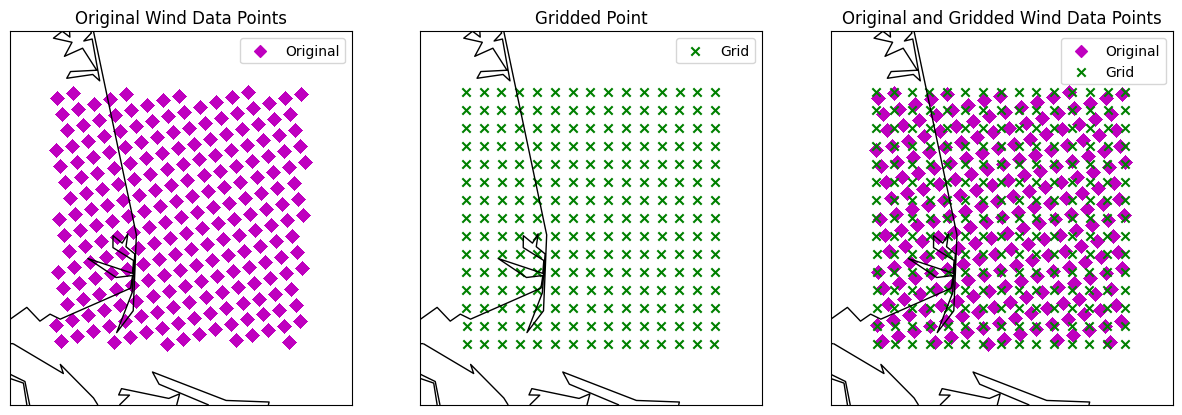

In [30]:
#We visualize here the original points and the grid points we just created
padding=0.1
fig = plt.figure(figsize=(15,15))

map = Basemap(llcrnrlon=lon_min-padding, llcrnrlat=lat_max+padding, urcrnrlon=lon_max+padding, urcrnrlat=lat_min-padding,
             resolution='i', projection='tmerc', lat_0 = 40.2, lon_0 = -73.85)

ax = fig.add_subplot(131)
x,y = map(lon, lat)

map.scatter(x, y, marker='D',color='m', label='Original')
map.drawcoastlines()
ax.set_title('Original Wind Data Points')
plt.legend()

ax = fig.add_subplot(132)
xx,yy = map(grid_y, grid_x)
map.scatter(xx, yy, marker='x',color='g', label='Grid')
map.drawcoastlines()
plt.legend()
ax.set_title('Gridded Point')

ax = fig.add_subplot(133)
map.scatter(x, y, marker='D',color='m', label='Original')
map.scatter(xx, yy, marker='x',color='g', label='Grid')
map.drawcoastlines()
ax.set_title('Original and Gridded Wind Data Points')
plt.legend()
plt.show()

In [31]:
#First we interpolate the data on our grid so the grid value match the nearest value for ws and wd
ws_gridded = np.zeros((len(time), len(lat_range), len(lon_range)))
wd_gridded = np.zeros_like(ws_gridded)

for i, _ in enumerate(time):
    ws_gridded[i,:] = griddata(locations, ws_h150.values[i,:], (grid_x, grid_y), method='nearest')
    wd_gridded[i,:] = griddata(locations, wd_h150.values[i,:], (grid_x, grid_y), method='nearest')

In [32]:
#Let's change the projection from cylindric to cartesian, going from (r, theta) to (u,v) projection.
u = ws_gridded*np.cos(wd_gridded)
v = ws_gridded*np.sin(wd_gridded)
speed = np.sqrt(u*u+v*v)

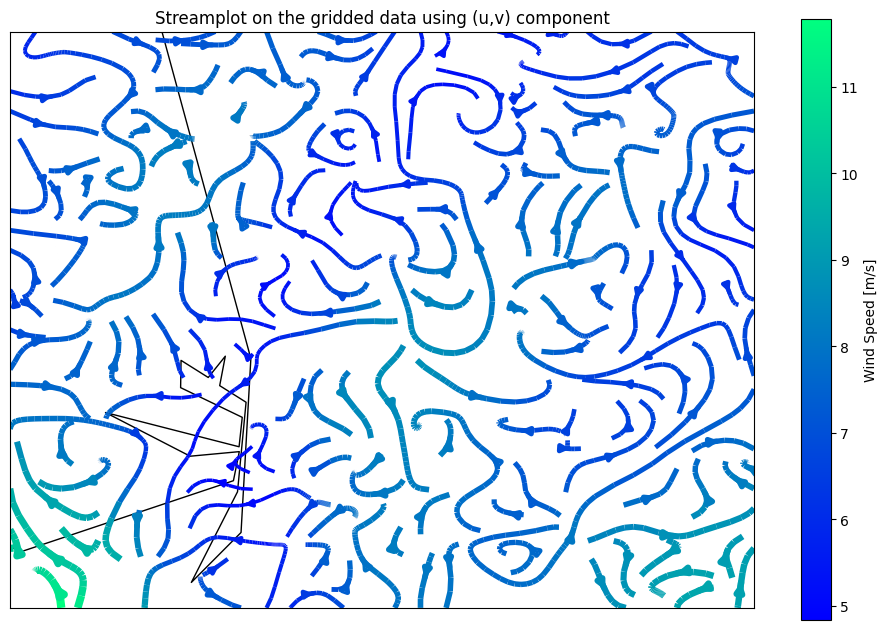

In [33]:
# We visualize the gridded point through a streamplot
padding=0

fig = plt.figure(figsize=(12,12))

map = Basemap(llcrnrlon=lon_min-padding, llcrnrlat=lat_max+padding, urcrnrlon=lon_max+padding, urcrnrlat=lat_min-padding,
             resolution='i', projection='cyl', lat_0 = 40.2, lon_0 = -73.85)

map.drawcoastlines()
xx, yy = map(grid_x[0,:], grid_y[:,0])
map.streamplot(yy, xx, u[0,:], v[0,:], color=speed[0,:], cmap=plt.cm.winter, linewidth=0.5*speed[0,:])
plt.colorbar(shrink=0.65, label='Wind Speed [m/s]')
plt.title("Streamplot on the gridded data using (u,v) component")
plt.show()


# Spatial Analysis, Gradient and Relative Vorticity

In this part we show a use case of gridding the data. When the data is properly gridded we can perform gradient calculation and calculate the relative vorticity of our dataset.


In [34]:
#Calculation of relative vorticity
#dx=grid_x[0,1]-grid_x[0,0]
geod = pyproj.Geod(ellps='WGS84')

# Function to calculate distances between grid points
def calculate_distances(longitude, latitude):
    # Preallocate arrays for distances (in meters)
    dist_lon = np.zeros_like(longitude)
    dist_lat = np.zeros_like(latitude)

    # Calculate distances in longitude direction (east-west)
    for i in range(longitude.shape[0]):
        for j in range(longitude.shape[1] - 1):
            _, _, dist_lon[i, j] = geod.inv(longitude[i, j], latitude[i, j],
                                           longitude[i, j + 1], latitude[i, j + 1])

    # Calculate distances in latitude direction (north-south)
    for i in range(latitude.shape[0] - 1):
        for j in range(latitude.shape[1]):
            _, _, dist_lat[i, j] = geod.inv(longitude[i, j], latitude[i, j],
                                           longitude[i + 1, j], latitude[i + 1, j])

    return dist_lon, dist_lat

#We calculate the distances
#Note: we calculate all the distances but this is only useful if your data scale >250km
dx, dy = calculate_distances(grid_y, grid_x)

#We average the dx and dy matrix since at our study scale on a small area
#W
dx = np.mean(dx)
dy = np.mean(dy)

In [35]:
#Calculating relative vorticity
dVdx = np.gradient(v, axis=2) / dx
dUdy = np.gradient(u, axis=1) / dy
relative_vorticity = dVdx - dUdy

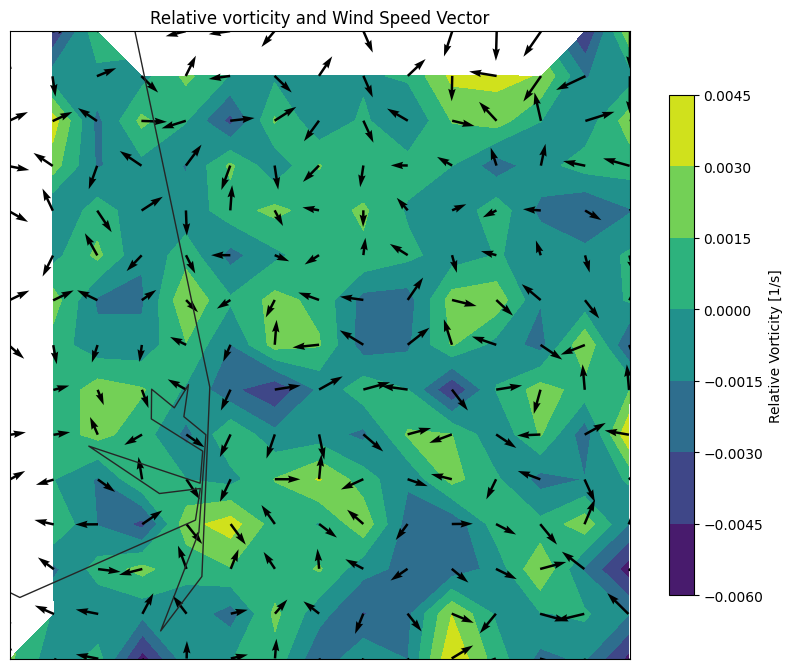

In [36]:
#Plotting the vorticity and wind speec vector
padding=0
fig = plt.figure(figsize=(10,10))

map = Basemap(llcrnrlon=lon_min-padding, llcrnrlat=lat_max+padding, urcrnrlon=lon_max+padding, urcrnrlat=lat_min-padding,
             resolution='i', projection='tmerc', lat_0 = 40.2, lon_0 = -73.85)

#map.fillcontinents(color='#cc9955', lake_color='aqua', zorder = 0)
map.drawcoastlines(color = '0.15')
xx, yy = map(grid_y, grid_x)
map.contourf(xx,yy,relative_vorticity[0,:])
map.quiver(xx, yy, u[0,:], v[0,:])
plt.title('Relative vorticity and Wind Speed Vector')
plt.colorbar(label='Relative Vorticity [1/s]', shrink=0.65)
plt.show()
